# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no
    changed in October by Thomas Bellotti

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [9]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [10]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [11]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10272 / 11441 MB available


In [17]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel (float * c, float * a, float * b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    // Do...
    // c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

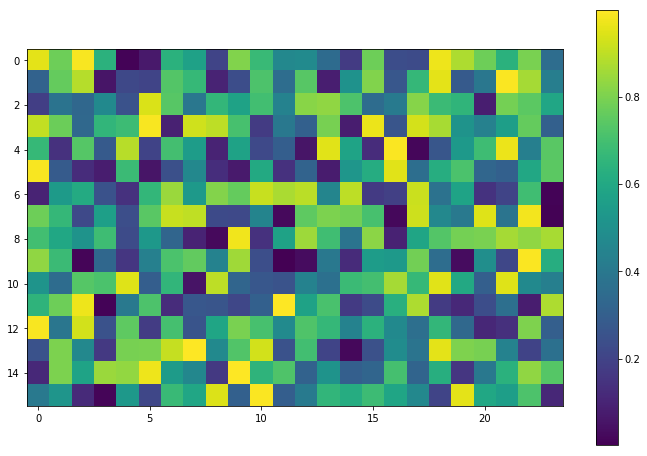

In [21]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize = (12,8))
plt.imshow(a)
plt.colorbar()
plt.show()

In [22]:
print(a.shape)

(16, 24)


In [23]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [24]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [43]:
# a.shape =  (rows, columns) --> [y,x]
domain_size = (a.shape[1],a.shape[0]) # Now domain size is [x,y]
block_size = (8,4,1) # This needs to be [x,y,z]
grid_size = (domain_size[0] // block_size[0], domain_size[0] // block_size[1], 1) # // is the integer division in modern python
print("Block size = " + str(block_size))
print("Grid size = " + str (grid_size))
print("Domain size = " + str(domain_size))

Block size = (8, 4, 1)
Grid size = (3, 6, 1)
Domain size = (24, 16)


In [47]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.0834615 , 1.5281368 , 1.8149612 , 1.6337386 , 0.24441738,
        0.7555903 , 0.99787664, 1.3846021 , 0.4354623 , 1.2255273 ,
        1.4758794 , 0.48964003, 0.56522506, 1.1789427 , 1.1522462 ,
        1.2021929 , 1.12947   , 0.90792936, 1.734854  , 1.3569767 ,
        1.1973104 , 0.7004903 , 1.6446102 , 1.1655009 ],
       [1.0565882 , 0.82113546, 1.6683561 , 0.32591105, 0.49372336,
        1.0593784 , 1.5355791 , 1.4044461 , 0.15887126, 0.3038419 ,
        1.6740857 , 1.1395177 , 0.9223587 , 0.67255604, 0.67521393,
        1.0001469 , 0.8853015 , 1.4605575 , 1.7938154 , 0.53800464,
        1.1898242 , 1.2071934 , 1.132252  , 0.6037556 ],
       [0.8790716 , 1.0625613 , 0.33838782, 1.0727799 , 0.46387196,
        1.3660516 , 1.3101726 , 0.677467  , 0.7843779 , 1.0472302 ,
        1.6388357 , 0.75323445, 1.4129784 , 1.6473043 , 1.1416485 ,
        1.2251991 , 1.2065946 , 0.9347696 , 0.7700708 , 1.3365352 ,
        0.44234762, 1.5862851 , 1.1261129 , 0.9311296 ],
       [1.117

In [48]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.0834615  1.5281368  1.8149612  1.6337386  0.24441738 0.7555903
  0.99787664 1.3846021  0.4354623  1.2255273  1.4758794  0.48964003
  0.56522506 1.1789427  1.1522462  1.2021929  1.12947    0.90792936
  1.734854   1.3569767  1.1973104  0.7004903  1.6446102  1.1655009 ]
 [1.0565882  0.82113546 1.6683561  0.32591105 0.49372336 1.0593784
  1.5355791  1.4044461  0.15887126 0.3038419  1.6740857  1.1395177
  0.9223587  0.67255604 0.67521393 1.0001469  0.8853015  1.4605575
  1.7938154  0.53800464 1.1898242  1.2071934  1.132252   0.6037556 ]
 [0.8790716  1.0625613  0.33838782 1.0727799  0.46387196 1.3660516
  1.3101726  0.677467   0.7843779  1.0472302  1.6388357  0.75323445
  1.4129784  1.6473043  1.1416485  1.2251991  1.2065946  0.9347696
  0.7700708  1.3365352  0.44234762 1.5862851  1.1261129  0.9311296 ]
 [1.1173426  1.1873872  1.0921302  0.9260248  0.9349743  1.5243571
  0.43206385 1.5899186  1.2121317  0.80091    0.5545784  0.8695101
  1.0065138  0.8428113  0.79058653 1.5000877  

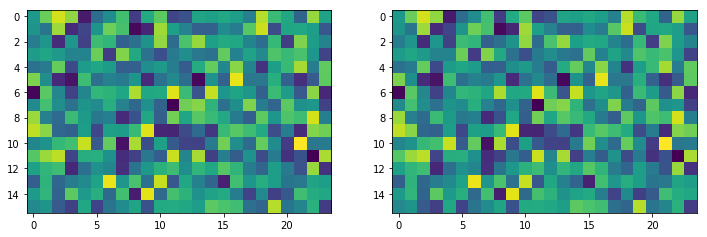

In [49]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)